# k近邻分类器



### 最近邻法(k=1)

#### 基本思想

对于一个新样本，把它逐一与已知样本比较，找出距离新样本最近的已知样本，以该样本的类别作为新样本的类别

#### 形式化表述

已知样本集：
$$
S_N=\{(x_1,\theta_1),(x_2,\theta_2)\cdots(x_N,\theta_N)\}
$$

其中$x_i$是样本$i$的特征向量，$\theta_i$是它对应的类别

定义两个样本间的距离度量$\delta(x_i,x_j)$，对未知样本$x$，求$S_N$中与之距离最近的样本，设为$x'$（对应的类别为$\theta '$），即
$$
\delta(x,x')=\min_{j=1,\cdots,N}\delta(x,x_j)
$$

则$x$的类别决策为$\theta '$

$\omega_i$类写成判别函数的形式：
$$
g_i(x)=\min_{x_j\in \omega_i}\delta(x,x_j), i=1,2,\cdots,c
$$

#### 距离的度量

常用的距离度量有欧式距离、曼哈顿距离等

欧式距离：
$$
\delta(x,x')=\sqrt{\sum_{i=1}^n(x_i-x_i')^2}
$$

曼哈顿距离：
$$
\delta(x,x')=\sum_{i=1}^n|x_i-x_i'|
$$

### k-近邻法

#### 基本思想

在很多情况下，把决策建立在一个最近的样本上有一定风险，因为这个样本可能是一个离群点，而且它的类别可能与样本集中的大多数样本不同

一种很自然的改进就是引入投票机制，即把新样本的类别决策建立在最近的$k$个样本上，以这$k$个样本中出现次数最多的类别作为新样本的类别

k-近邻法可以表示为：设有$N$个已知样本分属于c个类$\omega_i,i=1,\cdots,c$，考察新样本$x$在这些样本中的前$k$个最近邻，设其中有$k_i$个属于$\omega_i$，则$\omega_i$类的判别函数就是
$$
g_i(x)=k_i, i=1,2,\cdots,c
$$
决策规则是
$$
若g_k(x)=\max_{i=1,2,\cdots,c}g_i(x),则x\in \omega_k
$$

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy
import sympy
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [60]:
def loadDataSet():
    pathfile = '..\data.csv'
    dataset = pd.read_csv(pathfile,encoding="utf-8-sig")
    data=pd.DataFrame(dataset)
    data.replace('男\ufeff','男',inplace=True)    
    data.replace('女\ufeff','女',inplace=True)
    data.replace('\ufeff女','女',inplace=True)
    label = dataset.iloc[:, 3].values
    data = dataset.iloc[:, 0:3].values
    return np.array(data), np.array(label)

def split_dataset(data, label, ratio=0.8):
    # 划分训练集和测试集
    index = np.arange(len(label))
    np.random.shuffle(index)
    train_index = index[:int(len(index)*ratio)]
    test_index = index[int(len(index)*ratio):]
    train_data = data[train_index]
    train_label = label[train_index]
    test_data = data[test_index]
    test_label = label[test_index]
    return train_data, train_label, test_data, test_label

data, label = loadDataSet()
train_data, train_label, test_data, test_label = split_dataset(data, label, ratio=0.8)

In [61]:
class KNN:
    def __init__(self,data,label):
        self.data=data
        self.label=label
        self.test_data = []
        self.test_predict_label = []
        self.test_label = []
        self.test_pos_score = []


    def predict(self, x, k, dis='E',dispvote=False):
        votes = {}
        if dis == 'E':  # 欧氏距离
            dist = np.linalg.norm(self.data[:] - x, axis=1)
            #dist = np.power((np.power(self.data[:] - x, 2)).sum(axis=1), 0.5)
        elif dis == 'M':  # 曼哈顿距离
            dist = np.linalg.norm(self.data[:] - x, axis=1, ord=1)
            #dist = np.sum(np.abs(self.data[:, :] - x[:]), axis=1)  # 曼哈顿距离

        topK = np.argsort(dist)[:k]  # 选距离最接近的k个样本
        for m in topK:
            label = self.label[m]
            if dispvote:
                print(label,self.data[m],dist[m])
            votes.setdefault(label, 0)
            votes[label] += 1
        return max(votes, key=votes.get)

    # calculate the accuracy, need to call test() first
    def accuracy(self):
        return sum(self.test_pos_score) / len(self.test_pos_score)

    def test(self, k, dis, test_data = None, test_label = None):
        if test_data is not None:
            self.test_data = test_data
        if test_label is not None:
            self.test_label = test_label
        self.test_predict_label = [self.predict(x, k, dis) for x in self.test_data]
        self.test_pos_score = [self.test_predict_label[i] == self.test_label[i] for i, x in enumerate(self.test_data)]
        return self.test_predict_label, self.test_pos_score


    def testk(self, krange, dis, test_data = None, test_label = None, display=True):
        if test_data is not None:
            self.test_data = test_data
        if test_label is not None:
            self.test_label = test_label
        res = []
        for k in krange:
            self.test_predict_label = [self.predict(x, k, dis) for x in self.test_data]
            self.test_pos_score = [self.test_predict_label[i] == self.test_label[i] for i, x in enumerate(self.test_data)]
            err = 1 - self.accuracy()
            if display:
                print('dis = {}, k = {}, err = {}'.format(dis, k, err))
            res.append(err)
        return res


    def test_dis_k(self, krange, test_data = None, test_label = None, display=False):
        if test_data is not None:
            self.test_data = test_data
        if test_label is not None:
            self.test_label = test_label
        y_E = self.testk(krange, 'E', display=display)
        y_M = self.testk(krange, 'M', display=display)
        plt.title('Err VS K', fontsize=20,
                fontname='Times New Roman')
        plt.xlabel("K", fontsize="large")
        plt.ylabel("error rate", fontsize="large")
        plt.rcParams['font.sans-serif'] = ['SimHei']
        plt.plot(krange, y_E,color='green', label='Euclidean Distance')
        plt.plot(krange, y_M,color='skyblue', label='Manhattan Distance')
        plt.legend()  # 显示图例
        plt.show()


[178.  65.  41.]
男 [170.  52.  41.] 1.0
男 [170.  50.  42.] 1.4142135623730951
男 [170.  49.  41.] 2.0
男 [172.   51.2  41. ] 2.0099751242241783
男 [168.  52.  41.] 2.23606797749979
男 [168.  52.  41.] 2.23606797749979


'男'

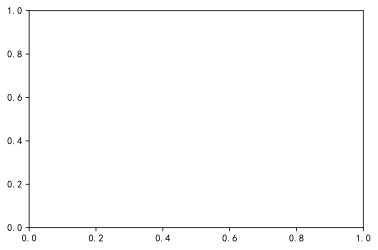

In [62]:
knn = KNN(train_data, train_label)
print(test_data[0])
knn.predict([170,51,41], 6, 'E', dispvote=True)



dis = E, k = 3, err = 0.051136363636363646
dis = E, k = 4, err = 0.05681818181818177
dis = E, k = 5, err = 0.08522727272727271
dis = E, k = 6, err = 0.07954545454545459
dis = E, k = 7, err = 0.09659090909090906
dis = E, k = 8, err = 0.07954545454545459
dis = M, k = 3, err = 0.05681818181818177
dis = M, k = 4, err = 0.045454545454545414
dis = M, k = 5, err = 0.09090909090909094
dis = M, k = 6, err = 0.07954545454545459
dis = M, k = 7, err = 0.08522727272727271
dis = M, k = 8, err = 0.07386363636363635


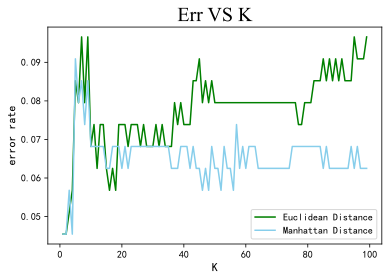

In [63]:
knn.testk(range(3, 9), 'E', test_data, test_label)
knn.testk(range(3, 9), 'M', test_data, test_label)
knn.test_dis_k(range(1, 100))

In [77]:
# for creating a responsive plot
%matplotlib widget

# importing required libraries
from mpl_toolkits.mplot3d import Axes3D

def plotErr3D(data, predict_label, correct_label):
    fig = plt.figure()
    # ax = fig.add_subplot(111, projection = '3d')
    ax = fig.add_subplot(111,projection="3d")
    for i in range(len(predict_label)):
        if predict_label[i] == '男':
            if predict_label[i] != correct_label[i]:
                s3 = ax.scatter(data[i, 0], data[i, 1], data[i, 2], c='c')
            else:
                s1 = ax.scatter(data[i, 0], data[i, 1], data[i, 2], c='b')
        else:
            if predict_label[i] != correct_label[i]:
                s4 = ax.scatter(data[i, 0], data[i, 1], data[i, 2], c='m')
            else:
                s2 = ax.scatter(data[i, 0], data[i, 1], data[i, 2], c='r')
    ax.set_xlabel('Height')
    ax.set_ylabel('Weight')
    ax.set_zlabel('Shoe Size')
    ax.legend((s1, s2, s3, s4), ('boys', 'girls', 'incorrect boys', 'incorrect girls'), loc='best')
    plt.show()

def plot3D(data, predict_label):
    fig = plt.figure()
    # ax = fig.add_subplot(111, projection = '3d')
    ax = fig.add_subplot(111,projection="3d")
    #ax = Axes3D(fig)
    # for i in range(len(predict_label)):
    #     if predict_label[i] == '男':
    #             s1 = ax.scatter(data[i, 0], data[i, 1], data[i, 2], c='b')
    #     else:
    #             s2 = ax.scatter(data[i, 0], data[i, 1], data[i, 2], c='r')
    male = data[np.where(predict_label=='男')]
    female = data[np.where(predict_label=='女')]
    ax.scatter(male[:, 0], male[:, 1], male[:, 2], c='b')
    ax.scatter(female[:, 0], female[:, 1], female[:, 2], c='r')
    ax.set_xlabel('Height')
    ax.set_ylabel('Weight')
    ax.set_zlabel('Shoe Size')
    #ax.legend((s1, s2), ('boys', 'girls'), loc='best')
    plt.show()

#knn.test(3, 'E', test_data, test_label)
#plotErr3D(test_data, knn.test_predict_label, test_label)

## 剪辑近邻法(Edited Nearest Neighbor, ENN)

### 基本思想

在很多情况下，两类数据的分布可能会有一定的重叠，如果训练样本处在重叠区域，那么分类器的分类效果就会变差

可以想到，如果能够把训练样本中处在重叠区域的样本去掉，那么分类器的分类效果就会变好

剪辑近邻法就是采用这样一种思想。

首先需要识别出那些处在边界区的样本。由于事先并不知道决策面的位置，因此需要通过训练样本来进行预分类。

一种有代表性的做法是，将已知样本分为测试集$S^{NT}$和训练集$S^{NR}$，对测试集中的每个样本，计算它在训练集中的最近邻，如果这个最近邻的类别与该样本的类别不同，则认为该样本处在边界区域。从$S^{NT}$去除这些分类错误的样本，剩余样本构成剪辑样本集$S^{NTE}$，用$S^{NTE}$对未来样本进行分类。

In [65]:
from collections import Counter
from sklearn.datasets import make_classification

from numpy import where
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

def plotAnim3D(animdata,algname = 'ENN'):
    # Attaching 3D axis to the figure
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    plt.cla()
    ax.set_xlabel('Height')
    ax.set_ylabel('Weight')
    ax.set_zlabel('Shoe Size')
    ax.set_autoscale_on(False)
    
    ax.set_xlim3d((140, 200))
    ax.set_ylim3d((35, 120))
    ax.set_zlim3d((35, 50))
    framenum = len(animdata)
    def update_lines(num):
        plt.cla()
        data = animdata[num][0]
        label = animdata[num][1]
        male = data[np.where(label=='男')]
        female = data[np.where(label=='女')]
        ax.set_title('{} at step {}\n male={} female={}'.format(algname,num,len(male),len(female)))
        ax.scatter(male[:, 0], male[:, 1], male[:, 2], c='b')
        ax.scatter(female[:, 0], female[:, 1], female[:, 2], c='r')
    # Creating the Animation object
    ani = animation.FuncAnimation(fig, update_lines, framenum, fargs=(), interval=1000,cache_frame_data=False,blit=False)
    plt.show()

    

In [66]:
from imblearn.under_sampling import EditedNearestNeighbours, RepeatedEditedNearestNeighbours
# summarize class distribution
counter = Counter(train_label)
print(counter)
# define the undersampling method
#undersample = EditedNearestNeighbours(n_neighbors=3)
undersample = EditedNearestNeighbours(n_neighbors=3)
res = [(train_data,train_label)]

for i in range(1,5):
    res.append(undersample.fit_resample(res[i-1][0], res[i-1][1]))
    counter = Counter(res[i][1])
    print(counter)

# plotAnim3D(res)

Counter({'男': 476, '女': 228})
Counter({'男': 450, '女': 228})
Counter({'男': 448, '女': 228})
Counter({'男': 448, '女': 228})
Counter({'男': 448, '女': 228})


In [67]:
# EditedNearestNeighbours
class ENN(KNN):
    def __init__(self, data, label):
        super(ENN,self).__init__(data,label)

    def editsample(self, k, dis='E'):
        # NR: Reference Set NT: Test Set
        NR_data,NR_label,NT_data,NT_label=split_dataset(self.data, self.label, 0.5)
        knn = KNN(NR_data, NR_label)
        _,iscorrect = knn.test(k,dis,NT_data,NT_label)
        newdata = np.array([NT_data[i] for i in range(len(NT_data)) if iscorrect[i]])
        newlabel = np.array([NT_label[i] for i in range(len(NT_label)) if iscorrect[i]])
        # self.data = newdata
        # self.label = newlabel
        self.data = np.concatenate((newdata,NR_data))
        self.label = np.concatenate((newlabel,NR_label))


Counter({'男': 476, '女': 228})
Counter({'男': 467, '女': 214})
Counter({'男': 464, '女': 211})
Counter({'男': 456, '女': 207})
Counter({'男': 452, '女': 194})
Counter({'男': 450, '女': 194})
Counter({'男': 450, '女': 194})
Counter({'男': 449, '女': 193})
Counter({'男': 446, '女': 192})
Counter({'男': 445, '女': 191})
Counter({'男': 445, '女': 191})


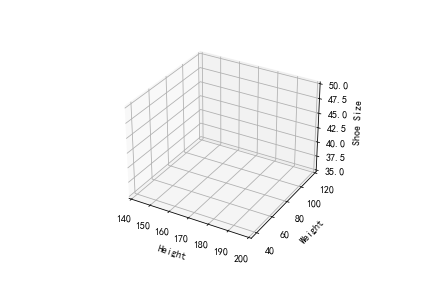

In [68]:
%matplotlib widget
enn = ENN(train_data, train_label)
res = [(train_data,train_label)]
print(Counter(train_label))
for i in range(10):
    enn.editsample(3, 'E')
    res.append((enn.data,enn.label))
    print(Counter(enn.label))
plotAnim3D(res)

# 若动画显示空白可以尝试重新执行上方包含plotAnim3D的单元格再尝试运行本单元格
# 若出现其它错误请清除变量后重新运行

## 压缩近邻法(Condensed Nearest Neighbor, CNN)

### 基本思想
在很多情况下，样本中远离分类边界的样本对于最后的分类决策并没有贡献

而针对于此，我们可以设法找出各类样本中最有利于用来与其他类区分的代表性样本，排除边缘样本，压缩训练样本数量已达到简化决策过程中的计算的目的。

早在1968年提出的CONDENSE算法就是采用了这一思想,称为压缩近邻法。

CONDENSE算法的做法是:将样本集$X^{N}$分为$X^{S}$和$X^{G}$两个活动的子集,前者称作储存集Storage,后者称作备选集GrabBag。算法开始时,$X^{S}$中只有一个样本,其余样本均在$X^{G}$中。考察$X^{G}$中的母一个样本 x ,若$X^{S}$中的样本能够对它正确分类,则该样本保留在$X^{G}$,否则移到出$X^{S}$中,依次类推,直到没有样本再需要搬移为止。最后用$X^{S}$中的样本作为代表样本,对未来样本进行近邻法分类。

### 算法步骤
1. **初始化** 初始样本集Storage是空集，原样本集存入Grabbag;从 Grabbag 中任意选择一样本放入 Storage 中作为新样本集的第一个样本。

2. **样本集生成** 在 Grabbag 中取出第 i 个样本用Storage中的当前样本集按最近邻法分类。若分类错误，则将该样本从 Grabbag 转入 Store 中;
若分类正确，则将该样本放回 Grabbag 中。

3. **结束过程** 若 Grabbag 中所有样本在执行第二步时没有发生转入 Storage的现象，或 Grabbag已成空集，则算法终止，否则转入第二步。


In [74]:
class CNN(KNN):
    def __init__(self, data, label):
        super(CNN,self).__init__(data,label)

    def resample(self, k, dis='E'):
        garbbag, garbbag_label = self.data,self.label

        first_add = len(garbbag) - 1# 从最后一个开始添加
        storage= np.array([garbbag[first_add]])
        # print(garbbag.shape)
        # print(storage.shape)
        storage_label = np.array([garbbag_label[first_add]])
        garbbag_label = np.delete(garbbag_label, first_add, 0)
        garbbag = np.delete(garbbag, first_add, 0)

        res=[(garbbag,garbbag_label)]
        # print(len(garbbag))
        # print(len(garbbag_label))

        while True :
            flag = 0
            # 从后往前predict garbbag集合
            i = len(garbbag) -1
            while i >= 0:
                knn = KNN(storage,storage_label)
                # _,iscorrect = knn.test(k,dis,garbbag,garbbag_label)
                label = knn.predict(garbbag[i], k, dis)
                if label != garbbag_label[i]:
                    storage = np.insert(storage,len(storage),garbbag[i],axis = 0)
                    storage_label = np.append(storage_label,garbbag_label[i])
                    # print(storage_label)
                    garbbag_label = np.delete(garbbag_label,i, 0)
                    garbbag = np.delete(garbbag,i, 0)
                    flag = 1
                i = i - 1
            if flag == 1 :
                print(Counter(storage_label))
                # res.append((garbbag ,garbbag_label))
                res.append((storage ,storage_label))
            else :
                print("压缩结束")
                print(len(storage))
                break


        self.data = storage
        self.label = storage_label
        return res



Counter({'男': 34, '女': 34})
Counter({'男': 37, '女': 37})
Counter({'女': 40, '男': 38})
压缩结束
78


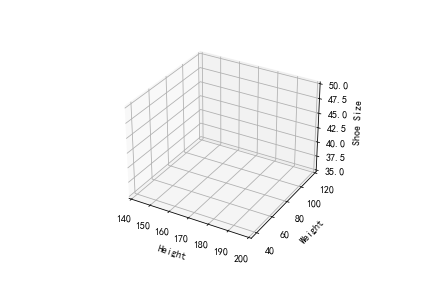

In [78]:

cnn = CNN(train_data, train_label)
res = cnn.resample(1, 'E')
# print(res)

# 每次只能展示一个动画，暂时注释以下代码

# % matplotlib widget
plotAnim3D(res,'Condensed')

In [ ]:
knn = KNN(train_data, train_label)
knn.test(3, 'E', test_data, test_label)
print("Accuracy of KNN: ", knn.accuracy())
enn.test(3, 'E', test_data, test_label)
print("Accuracy of ENN: ", enn.accuracy())
cnn.test(3, 'E', test_data, test_label)
print("Accuracy of CNN: ", cnn.accuracy())